<a href="https://colab.research.google.com/github/10100111/Display-of-HW1/blob/main/22b_Light_%D0%A0%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B8_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D0%B8_(%D0%A3%D0%BD%D0%B8%D0%B2%D0%B5%D1%80%D1%81%D0%B8%D1%82%D0%B5%D1%82_%D0%B8%D1%81%D0%BA%D1%83%D1%81%D1%81%D1%82%D0%B2%D0%B5%D0%BD%D0%BD%D0%BE%D0%B3%D0%BE_%D0%B8%D0%BD%D1%82%D0%B5%D0%BB%D0%BB%D0%B5%D0%BA%D1%82%D0%B0).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание Lite

Макс 10 баллов

Используя шаблон ноутбука, используйте базу квартир чтобы осуществить следующее следующее:

Загрузить xTrain на числовых данных.
Загрузить xTrainС из Примечаний (тексты).
Создать словарь.

Превратить xTrainC в формат bag of words (2000 самых популярных слов).

Сделать нормирование данных.
Написать нейронную сеть.
 

# Загрузка данных

In [ ]:
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, LSTM, Conv1D, Conv2D, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import LambdaCallback

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

import random 
import math

import re 
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Базы/moscow.csv', sep = ';')

In [ ]:
df.head(5)

,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб.",ГРМ,Бонус агенту,Дата,Кол-во дней в экспозиции,Источник,Примечание
0,1,Шелепиха м.,12п,35/37 М,NaN,2,64.1/23/20,19500000.0,NaN,NaN,25.07.2019,1.0,Привлекательные,Собственность оформлена! Ключи на руках! Опера...
1,Для заметок:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Пятницкое шоссе м.,30т,11/14 П,Л,Р,38.4/17/9,4800000.0,NaN,NaN,25.07.2019,2.0,Привлекательные,Зеленоград к.1820 однокомнатная квартира общ.3...
3,Для заметок:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Планерная м.,5т,11/22 П,Б,С,38.2/19.9/9.9,7990000.0,NaN,NaN,25.07.2019,4.0,Привлекательные,"Уютная, светлая квартира, застекленный балкон ..."


In [ ]:
df = df.iloc[::2,:] #выбираем нечетные строки, т.к. в четных строки для комментариев
data = df.values # добавляем значения в numpy array


In [ ]:
df.head(5)

,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб.",ГРМ,Бонус агенту,Дата,Кол-во дней в экспозиции,Источник,Примечание
0,1,Шелепиха м.,12п,35/37 М,NaN,2,64.1/23/20,19500000.0,NaN,NaN,25.07.2019,1.0,Привлекательные,Собственность оформлена! Ключи на руках! Опера...
2,1,Пятницкое шоссе м.,30т,11/14 П,Л,Р,38.4/17/9,4800000.0,NaN,NaN,25.07.2019,2.0,Привлекательные,Зеленоград к.1820 однокомнатная квартира общ.3...
4,1,Планерная м.,5т,11/22 П,Б,С,38.2/19.9/9.9,7990000.0,NaN,NaN,25.07.2019,4.0,Привлекательные,"Уютная, светлая квартира, застекленный балкон ..."
6,1,Шаболовская м.,12п,8/12 ?,Б,Р,38/15/7,11200000.0,NaN,NaN,25.07.2019,7.0,Привлекательные,"Предлагаю 1- комн квартиру, в шаговой доступно..."
8,1,Бабушкинская м.,15п,4/14 П,NaN,С,34/17/8,6250000.0,NaN,NaN,25.07.2019,11.0,Привлекательные,Продается хорошая 1 комнатная квартира. 1 взро...


In [ ]:
print(df.columns) #смотрим имена колонок данных
#Мы будем использовать

#В xTrain - база числовых значени
#Комнат
#Метро / ЖД станции
#От станции
#Дом
#Балкон
#Санузел
#Площадь

#В xTrainC - база текстов о квартирах
#Примечание

#В yTrain
#Цена, руб.

#Остальные колонки игнорируем

Index(['Комнат', 'Метро / ЖД станции', 'От станции', 'Дом', 'Балкон',
       'Санузел', 'Площадь', 'Цена, руб.', 'ГРМ', 'Бонус агенту', 'Дата',
       'Кол-во дней в экспозиции', 'Источник', 'Примечание'],
      dtype='object')


#Функции парсинга

*Разбор данного раздела:* https://youtu.be/h8cOCvlYmN8?t=2126

In [ ]:
#Во всех функция дальше
#d - описание квартиры, одна строка из data1

#Вычисляем количество комнат
#maxRoomCount - максимальное число комнат в квартире
def getRoomsCount(d, maxRoomCount):
  roomsCountStr = d[0] #Получаем строку с числом комнат

  roomsCount = 0
  try:
    roomsCount = int(roomsCountStr) #Пробуем превратить строку в число
    if (roomsCount > maxRoomCount): 
      roomsCount = maxRoomCount #Если число комнат больше максимального, то присваиваем максимальное
  except: #Если не получается превратить строку в число
    if (roomsCountStr == roomsCountStr): #Проверяем строку на nan (сравнение с самим собой)
      if ("Ст" in roomsCountStr): #Еcть строка = "Ст", значит это Студия
        roomsCount = maxRoomCount + 1

  return roomsCount

#Превращаем число комнат в категорию
def getRoomsCountCategory(d, maxRoomCount):
  roomsCount = getRoomsCount(d, maxRoomCount) #Получаем число комнат
  roomsCount = utils.to_categorical(roomsCount, maxRoomCount+2) #Превращаем в категорию
  #maxRoomCount+2 потому что 0 зарезервирован на неопознаное число комнат, а maxRoomCount+1 на "Студию"
  return roomsCount

#Получаем индекс станции метро
#allMetroNames - все уникальные названия метро в базе
def getMetro(d, allMetroNames):
  metroStr = d[1] #Получаем строку метро
  metro = 0
  
  if (metroStr in allMetroNames): #Если находим метро во всех названиях
    metro = allMetroNames.index(metroStr)+1 #Присваиваем индекс
    #+1 так как 0 зарезервирован на неопознанное метро
    
  return metro

#Получаем тип метро
#0 - внутри кольца
#1 - кольцо
#2 - 1-3 станции от конца
#3 - 4-8 станций от кольца
#4 - больше 8 станций от кольца
def getMetroType(d):
  metroTypeStr = d[1] #Получаем строку метро
  metroTypeClasses = 5 #Число классов метро
  metroType = metroTypeClasses - 1 #Изначально считаем последний класс
  
  #Метро внутри кольца
  metroNamesInsideCircle = ["Площадь Революции", "Арбатская", "Смоленская", "Красные Ворота", "Чистые пруды", "Лубянка", "Охотный Ряд", "Библиотека имени Ленина", "Кропоткинская", "Сухаревская", "Тургеневская", "Китай-город", "Третьяковская", "Трубная", "Сретенский бульвар", "Цветной бульвар", "Чеховская", "Боровицкая", "Полянка", "Маяковская", "Тверская", "Театральная", "Новокузнецкая", "Пушкинская", "Кузнецкий Мост", "Китай-город", "Александровский сад"]
  #Метро на кольце
  metroNamesCircle = ["Киевская", "Парк Культуры", "Октябрьская", "Добрынинская", "Павелецкая", "Таганская", "Курская", "Комсомольская", "Проспект Мира", "Новослободская", "Белорусская", "Краснопресненская"]
  #Метро 1-3 станции от кольца
  metroNames13FromCircle = ["Бауманская", "Электрозаводская", "Семёновская", "Площадь Ильича", "Авиамоторная", "Шоссе Энтузиастов", "Римская", "Крестьянская Застава", "Дубровка", "Пролетарская", "Волгоградский проспект", "Текстильщики", "Автозаводская", "Технопарк", "Коломенская", "Тульская", "Нагатинская", "Нагорная", "Шаболовская", "Ленинский проспект", "Академическая", "Фрунзенская", "Спортивная", "Воробьёвы горы", "Студенческая", "Кутузовская", "Фили", "Парк Победы", "Выставочная", "Международная", "Улица 1905 года", "Беговая", "Полежаевская", "Динамо", "Аэропорт", "Сокол", "Деловой центр", "Шелепиха", "Хорошёвская", "ЦСКА", "Петровский парк", "Савёловская", "Дмитровская", "Тимирязевская", "Достоевская", "Марьина Роща", "Бутырская", "Фонвизинская", "Рижская", "Алексеевская", "ВДНХ", "Красносельская", "Сокольники", "Преображенская площадь"]
  #Метро 4-8 станций от кольа
  metroNames48FromCircle = ["Партизанская", "Измайловская", "Первомайская", "Щёлковская", "Новокосино", "Новогиреево", "Перово", "Кузьминки", "Рязанский проспект", "Выхино", "Лермонтовский проспект", "Жулебино", "Партизанская", "Измайловская", "Первомайская", "Щёлковская", "Новокосино", "Новогиреево", "Перово", "Кузьминки", "Рязанский проспект", "Выхино", "Лермонтовский проспект", "Жулебино", "Улица Дмитриевского", "Кожуховская", "Печатники", "Волжская", "Люблино", "Братиславская", "Коломенская", "Каширская", "Кантемировская", "Царицыно", "Орехово", "Севастопольская", "Чертановская", "Южная", "Пражская", "Варшавская", "Профсоюзная", "Новые Черёмушки", "Калужская", "Беляево", "Коньково", "Университет", "Багратионовская", "Филёвский парк", "Пионерская", "Кунцевская", "Молодёжная", "Октябрьское Поле", "Щукинская", "Спартак", "Тушинская", "Сходненская", "Войковская", "Водный стадион", "Речной вокзал", "Беломорская", "Ховрино", "Петровско-Разумовская", "Владыкино", "Отрадное", "Бибирево", "Алтуфьево", "Фонвизинская", "Окружная", "Верхние Лихоборы", "Селигерская", "ВДНХ", "Ботанический сад", "Свиблово", "Бабушкинская", "Медведково", "Преображенская площадь", "Черкизовская", "Бульвар Рокоссовского"]
  
  #Проверяем, в какую категорию попадает наша станция
  if (metroTypeStr in metroNamesInsideCircle):
    metroType = 0
  if (metroTypeStr in metroNamesCircle):
    metroType = 1
  if (metroTypeStr in metroNames13FromCircle):
    metroType = 2
  if (metroTypeStr in metroNames48FromCircle):
    metroType = 3
  
  #Превращаем результат в категорию
  metroType = utils.to_categorical(metroType, metroTypeClasses)
  return metroType


#Вычисляем растояние до метро
def getMetroDistance(d):
  metroDistanceStr = d[2] #Получаем строку
  
  metroDistance = 0 #Расстояние до метро
  metroDistanceType = 0 #Тип расстояния - пешком или на транспорте
  
  #ЕСли строка не равна nan  
  if (metroDistanceStr == metroDistanceStr):
    if (len(metroDistanceStr) > 0):
      #Определяем тип расстояния
      if (metroDistanceStr[-1] == "п"):
        metroDistanceType = 1 #Пешком
      elif (metroDistanceStr[-1] == "т"):
        metroDistanceType = 2 #На транспорте

      #Выбрасываем последний символ, чтобы осталось только число
      metroDistanceStr = metroDistanceStr[:-1]
      try:
        #Разделяем дистанции на категории
        metroDistance = int(metroDistanceStr)
        if (metroDistance < 3):
          metroDistance = 1
        elif (metroDistance < 6):
          metroDistance = 2
        elif (metroDistance < 10):
          metroDistance = 3
        elif (metroDistance < 15):
          metroDistance = 4
        elif (metroDistance < 20):
          metroDistance = 5
        else:
          metroDistance = 6
      except: #Если в строке не число, то категория 0
        metroDistance = 0
  
  #Число классов дистанции
  metroDistanceClasses = 7
  
  #У нас 7 категорий дистанции по расстоянию
  #И 3 типа дистанции - неопознанный, пешком и транспортом
  #Мы создадим вектор длины 3*7 = 21
  #Будем преобразовывать индекс расстояния 0-6 в 0-20
  #Для типа "Пешком" - ничего не меняем
  if (metroDistanceType == 2):
    metroDistance += metroDistanceClasses #Для типа "Транспортом" добавляем 7
  if (metroDistanceType == 0):
    metroDistance += 2*metroDistanceClasses #Для неопознанного типа добавляем 14
    
  #Превращаем в категории
  metroDistance = utils.to_categorical(metroDistance, 3*metroDistanceClasses)
  return metroDistance

#Получаем 4 данных
#- этаж квартиры
#- этажность дома
#- индикатор, что последний этаж
#- тип дома
def getHouseTypeAndFloor(d):
  try:
    houseStr = d[3] #Получаем строку типа дома и этажей
  except:
    houseStr = ""
  
  houseType = 0 #Тип дома
  floor = 0 #Этаж квартиры
  floors = 0 #Этажность дома
  isLastFloor = 0 #Индикатор последнего этажа
  
  #Проверяем строку на nan
  if (houseStr == houseStr):
    if (len(houseStr) > 1):
    
      try:
        slashIndex = houseStr.index("/") #Ищем разделитель /
      except:
        print(houseStr)

      try:
        spaceIndex = houseStr.index(" ") #Ищем разделитель " "
      except:
        print(houseStr)

      #Вытаскиваем строки
      floorStr = houseStr[:slashIndex] #Строка этажа
      floorsStr = houseStr[slashIndex+1:spaceIndex] #Строка этажнгости дома
      houseTypeStr = houseStr[spaceIndex+1:] #Строка типа дома

      #Выбираем категорию этажа
      try:
        floor = int(floorStr) #Превращаем строку в число
        floorSave = floor
        if (floorSave < 5):
          floor = 2
        if (floorSave < 10):
          floor = 3
        if (floorSave < 20):
          floor = 4
        if (floorSave >= 20):
          floor = 5
        if (floorSave == 1): #Первый этаж выделяем в отдельную категорию
          floor = 1 

        if (int(floorStr) == int(floorsStr)): #Если этаж последний, включаем индикатор последнего этажа
          isLastFloor = 1 
      except:
        floor = 0 #Если строка не парсится в число, то категория этажа = 0 (отдельная)

      #Выбираем категорию этажности дома
      try:
        floors = int(floorsStr) #Превращаем строку в число
        floorsSave = floors
        if (floorsSave < 5):
          floors = 1
        if (floorsSave < 10):
          floors = 2
        if (floorsSave < 20):
          floors = 3
        if (floorsSave >= 20):
          floors = 4
      except:
        floors = 0 #Если строка не парсится в число, то категория этажности = 0 (отдельная)

      #Определяем категорию типа дома
      if (len(houseTypeStr) > 0):
        if ("М" in houseTypeStr): 
          houseType = 1
        if ("К" in houseTypeStr): 
          houseType = 2
        if ("П" in houseTypeStr): 
          houseType = 3
        if ("Б" in houseTypeStr): 
          houseType = 4
        if ("?" in houseTypeStr): 
          houseType = 5
        if ("-" in houseTypeStr): 
          houseType = 6
    
    #Превращаем все категории в one hot encoding
    floor = utils.to_categorical(floor, 6)
    floors = utils.to_categorical(floors, 5)
    houseType = utils.to_categorical(houseType, 7)
    
    
  return floor, floors, isLastFloor, houseType


#Вычисляем тип балкона
def getBalcony(d):
  balconyStr = d[4] #Полуаем строку
  #Выписываем все варианты балконов в базе
  balconyVariants = ['Л', 'Б', '2Б', '-', '2Б2Л', 'БЛ', '3Б', '2Л', 'Эрк', 'Б2Л', 'ЭркЛ', '3Л', '4Л', '*Л', '*Б']
  #Проверяем на nan
  if (balconyStr == balconyStr):
    balcony = balconyVariants.index(balconyStr)+1 #Находим индекс строки балкона во всех строках
  else:
    balcony = 0 #Индекс 0 выделяем на строку nan
  
  #Превращаем в one hot encoding
  balcony = utils.to_categorical(balcony, 16)
  
  return balcony

#Определяем тип санузла
def getWC(d):
  wcStr = d[5] #Получаем строку
  #Выписываем все варианты санузлов в базе
  wcVariants = ['2', 'Р', 'С', '-', '2С', '+', '4Р', '2Р', '3С', '4С', '4', '3', '3Р']
  #Проверяем на nan
  if (wcStr == wcStr):
    wc = wcVariants.index(wcStr)+1 #Находим индекс строки санузла во всех строках
  else:
    wc = 0 #Индекс 0 выделяем на строку nan
  
  #Превращаем в one hot encoding
  wc = utils.to_categorical(wc, 14)
  
  return wc

#Определяем площадь
def getArea(d):
  areaStr = d[6] #Поулачем строку площади
  
  if ("/" in areaStr):
    slashIndex = areaStr.index("/") #Находим разделитель /
    try:
      area = float(areaStr[:slashIndex]) #Берём число до разделителя и превращаем в число
    except:
      area = 0 #Если не получается, возвращаем 0
  else:
    area = 0 #Или если нет разделителя, возвращаем 0
    
  return area

#Получаем цену
def getCost(d):
  costStr = d[7] #Загружаем строку
  
  try:
    cost = float(costStr) #Пробуем превратить в число
  except:
    cost = 0 #Если не получается, возвращаем 0
  
  return cost

#Получаем комментарий
def getComment(d):
  commentStr = d[-1] #Возвращаем данные из последней колонки
  
  return commentStr

#Объединяем все числовые параметры вместе
def getAllParameters(d, allMetroNames):
  #Загружаем все данные по отдельности
  roomsCountType = getRoomsCountCategory(d, 30)
  metro = getMetro(d, allMetroNames)
  metroType = getMetroType(d)
  metroDistance = getMetroDistance(d)
  floor, floors, isLastFloor, houseType = getHouseTypeAndFloor(d)
  balcony = getBalcony(d)
  wc = getWC(d)
  area = getArea(d)

  #Объединяем в один лист
  out = list(roomsCountType)
  out.append(metro)
  out.extend(metroType)
  out.extend(metroDistance)
  out.extend(floor)
  out.extend(floors)
  out.append(isLastFloor)
  out.extend(houseType)
  out.extend(balcony)
  out.extend(wc)
  out.append(area)
  
  return out

#Генерируем обучающаюу выборку - xTrain
def getXTrain(data):
  
  #Получаем строку во всеми вариантами метро
  allMertroNames = list(df["Метро / ЖД станции"].unique())
  
  #Всевращаем все строки в data1 в векторы параметров и записываем в xTrain
  xTrain = [getAllParameters(d, allMertroNames) for d in data]
  xTrain = np.array(xTrain)
  
  return xTrain

#Генерируем обучающую выборку - yTrain
def getYTrain(data):
  
  #Зашружаем лист всех цен квартир по всем строкам data1
  costList = [getCost(d) for d in data] 
  yTrain = np.array(costList)
  
  return yTrain

# Создание выборки


In [ ]:
oneRoomMask = [getRoomsCount(d, 30) == 1 for d in data] #Делаем маску однокомнатных квартир, принцип (getRoomsCount(d, 30) == 1)
data1 = data[oneRoomMask] #В data1 оставляем только однокомнатные квартиры
print(data.shape)
print(data1.shape)

(126268, 14)
(62504, 14)


In [ ]:
xTrain = getXTrain(data1)
yTrain = getYTrain(data1)
print(xTrain.shape)

(62504, 109)


In [ ]:
print(xTrain[0][-1])

64.1


In [ ]:
###########################
# Формируем обучающую выборку из примечаний к квартирам
# Пока в виде слов
##########################
def getXTrainComments(data):
  xTrainComments = [] #Тут будет обучающая выборка
  allTextComments = "" #Тут будуте все тексты вместе для словаря
  
  #Идём по всем строкам квартир в базе
  for d in data:
    currText = getComment(d) #Вытаскиваем примечание к квартире
    try: 
      if (currText == currText): #Проверяем на nan
        allTextComments += currText + " " #Добавляем текст в общий текст для словаря
    except:
      currText = "Нет комментария" #Если не получается, то делаем стандартный текст "Нет комментария"
    xTrainComments.append(currText) #Добавляем примечание новой строкой в обучающую выборку
  
  xTrainComments = np.array(xTrainComments)
  
  return (xTrainComments, allTextComments)

# Создание xTrain (cобираем по текстам)

In [ ]:
xTrainC, allTextComments = getXTrainComments (data1)  #создали обучающую выборку по текстам и полную для словаря


In [ ]:
print(xTrainC[0])
print(allTextComments[:30])

Собственность оформлена! Ключи на руках! Оперативный показ и выход на сделку! Свободная продажа! Предлагаем приобрести апартаменты премиального уровня в ЖК «Сердце столицы» с шикарными видовыми характеристиками (смотрите фото), таких предложений в данном ЖК - нет! Реальные живые фото, из личного архива! Закрытая территория, уютные и безопасные дворы без автомобилей, подземный паркинг с автомойками, имеется м/м за отдельную плату, круглосуточная охрана. Собственная инфраструктура включает фитнес-центр, стадион, беговые и велосипедные дорожки, скейт-парк, йога-центры, летний театр, 500-метровая набережная с пляжной зоной и причалом, на территории будет располагаться собственная школа и детский сад и т.д. В шаговой доступности метро: Шелепиха, Международная, Деловой центр, Выставочная, Фили. Удобная транспортная доступность. Звоните! Может именно это предложение Вы уже давно ищете!
Собственность оформлена! Ключи


In [ ]:
maxWordsCount = 2000
tokenizer = Tokenizer(num_words = maxWordsCount, filters = '–—!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\xa0–\ufeff', lower = True, split = ' ', char_level = False, oov_token = 'unknown')
tokenizer.fit_on_texts(xTrainC)
items = list(tokenizer.word_index.items()) #вытаскиваем индексы слов для просмотра

In [ ]:
print(items[:30])

[('unknown', 1), ('в', 2), ('и', 3), ('на', 4), ('с', 5), ('от', 6), ('м', 7), ('квартира', 8), ('1', 9), ('кв', 10), ('для', 11), ('метро', 12), ('по', 13), ('до', 14), ('дома', 15), ('жк', 16), ('2', 17), ('продается', 18), ('комплекс', 19), ('5', 20), ('3', 21), ('парк', 22), ('доступности', 23), ('рядом', 24), ('москвы', 25), ('этаже', 26), ('из', 27), ('без', 28), ('жилой', 29), ('комплекса', 30)]


In [ ]:
# преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(xTrainC) # обучающие тексты в индексы

In [ ]:
print(trainWordIndexes[:30])

[[422, 1, 449, 4, 1550, 306, 243, 3, 229, 4, 259, 77, 55, 1804, 1932, 197, 1, 1326, 2, 16, 1, 1, 5, 1, 1, 1, 1, 1253, 1, 1, 2, 1, 16, 367, 1, 1, 1253, 27, 1, 1, 453, 104, 641, 3, 1748, 288, 28, 227, 96, 67, 5, 1, 670, 7, 7, 172, 1, 1, 570, 381, 500, 36, 370, 126, 60, 689, 1, 3, 1490, 965, 1, 22, 1, 110, 709, 1033, 1627, 1, 767, 5, 1, 642, 3, 1, 4, 56, 107, 1, 500, 41, 3, 69, 39, 3, 622, 201, 2, 57, 23, 12, 1280, 1, 991, 60, 1, 831, 380, 182, 145, 154, 1583, 1321, 71, 456, 335, 261, 1, 1], [1, 53, 1, 91, 8, 938, 485, 45, 174, 105, 103, 5, 586, 605, 818, 10, 7, 31, 43, 24, 101, 1, 1, 143, 1895, 161, 1895, 15, 224, 149, 1154, 1125, 418, 77, 55, 243, 2, 868, 217, 449, 4, 1550], [232, 233, 8, 1371, 228, 4, 597, 558, 81, 5, 166, 115, 33, 34, 92, 44, 136, 24, 22, 1, 1414, 1, 1, 1, 503, 3, 839, 2, 1, 717, 6, 15], [1, 9, 66, 140, 2, 57, 23, 6, 45, 242, 610, 12, 233, 2, 793, 416, 173, 155, 450, 228, 5, 1282, 27, 283, 3, 284, 1, 269, 1425, 970, 114, 1, 332, 1, 1, 1078, 418, 141, 210, 170, 116, 37

In [ ]:
#BOW
xTrainC01 = tokenizer.sequences_to_matrix(trainWordIndexes)

In [ ]:
# выводим размеры обучающей выборки
#Чтобы проверить, что мы всё правильно собрали
print(xTrain.shape)
print(xTrainC01.shape)
print(yTrain.shape)

(62504, 109)
(62504, 2000)
(62504,)


In [ ]:
#Нормируем размер квартиры в xTrain
xScaler = StandardScaler() #Создаём нормировщик нормальным распределением
xScaler.fit(xTrain[:,-1].reshape(-1, 1)) #Обучаем его на площадях квартир (последня колонка в xTrain)
xTrainScaled = xTrain.copy()
xTrainScaled[:,-1] = xScaler.transform(xTrain[:,-1].reshape(-1, 1)).flatten() #Нормируем данные нормировщиком


In [ ]:
#Выводим размер и два примера для сравнения
#Не нормированных данных и нормированных
print(xTrainScaled.shape)
print(xTrain[0])
print(xTrainScaled[0])

(62504, 109)
[ 0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.
  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.
  0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  64.1]
[0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 1.         0.         0.  

In [ ]:
# Нормируем цену квартиры
yScaler = StandardScaler()  # Делаем нормировщик 
yScaler.fit(yTrain.reshape(-1, 1)) #Нормируем цены квартир
yTrainScaled = yScaler.transform(yTrain.reshape(-1, 1))


In [ ]:
# выводим два примера нормированных и ненормированных данных для сравнения
print(yTrainScaled.shape)
print(yTrain[0])
print(yTrainScaled[0])

(62504, 1)
19500000.0
[0.45013]


In [ ]:
print(min(yTrain), max(yTrain))
print(min(yTrainScaled), max(yTrainScaled))

1500000.0 3000000015.0
[-0.3458729] [132.25494456]


In [ ]:
splitVal = 0.2 #Процент, который выделяем в проверочную выборку
valMask = np.random.sample(xTrainScaled.shape[0]) < splitVal

In [ ]:
np.save('/content/drive/MyDrive/Colab Notebooks/Базы/xTrainScaled', xTrainScaled)
np.save('/content/drive/MyDrive/Colab Notebooks/Базы/xTrainC01', xTrainC01)
np.save('/content/drive/MyDrive/Colab Notebooks/Базы/yTrainScaled', yTrainScaled)

# Нейросеть

In [ ]:
def on_epoch_end(epoch, logs):
  pred = model.predict([xTrainScaled[valMask], xTrainC01[valMask]]) #Полуаем выход сети на проверочно выборке
  predUnscaled = yScaler.inverse_transform(pred).flatten() #Делаем обратное нормирование выхода к изначальным величинам цен квартир
  yTrainUnscaled = yScaler.inverse_transform(yTrainScaled[valMask]).flatten() #Делаем такое же обратное нормирование yTrain к базовым ценам
  delta = predUnscaled - yTrainUnscaled #Считаем разность предсказания и правильных цен
  absDelta = abs(delta) #Берём модуль отклонения
  print("Эпоха", epoch, "модуль ошибки", round(sum(absDelta) / (1e+6 * len(absDelta)),3)) #Выводим усреднённую ошибку в миллионах рублей

# Коллбэки
pltMae = LambdaCallback(on_epoch_end=on_epoch_end)

In [ ]:
print(type(xTrainScaled))
print(type(xTrainC01))
print(type(yTrainScaled))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


Эпоха 0 модуль ошибки 2.08
Эпоха 1 модуль ошибки 2.057
Эпоха 2 модуль ошибки 1.829
Эпоха 3 модуль ошибки 1.624
Эпоха 4 модуль ошибки 1.566
Эпоха 5 модуль ошибки 1.537
Эпоха 6 модуль ошибки 1.541
Эпоха 7 модуль ошибки 1.44
Эпоха 8 модуль ошибки 1.392
Эпоха 9 модуль ошибки 1.417
Эпоха 10 модуль ошибки 1.582
Эпоха 11 модуль ошибки 1.313
Эпоха 12 модуль ошибки 1.548
Эпоха 13 модуль ошибки 1.298
Эпоха 14 модуль ошибки 1.341
Эпоха 15 модуль ошибки 1.486
Эпоха 16 модуль ошибки 1.663
Эпоха 17 модуль ошибки 1.313
Эпоха 18 модуль ошибки 1.512
Эпоха 19 модуль ошибки 1.259
Эпоха 20 модуль ошибки 1.481
Эпоха 21 модуль ошибки 1.27
Эпоха 22 модуль ошибки 1.628
Эпоха 23 модуль ошибки 1.218
Эпоха 24 модуль ошибки 1.506
Эпоха 25 модуль ошибки 1.202
Эпоха 26 модуль ошибки 1.173
Эпоха 27 модуль ошибки 1.12
Эпоха 28 модуль ошибки 1.336
Эпоха 29 модуль ошибки 1.152
Эпоха 30 модуль ошибки 1.347
Эпоха 31 модуль ошибки 1.358
Эпоха 32 модуль ошибки 1.111
Эпоха 33 модуль ошибки 1.111
Эпоха 34 модуль ошибки 1.276

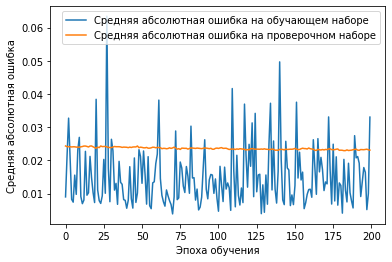

In [ ]:
# Простая Dense cеть

input1 = Input((xTrainScaled.shape[1],))
input2 = Input((xTrainC01.shape[1],))

x1 = Dense(64, activation="relu")(input1)
x1 = Dropout(0.3)(x1)
x1 = Dense(32, activation="relu")(x1)

x2 = Dense(256, activation="relu")(input2)
x2 = Dropout(0.25)(x2)
x2 = Dense(64, activation="relu")(x2)

x = concatenate([x1, x2])

x = Dense(100, activation='relu')(x)
x = Dense(10, activation='relu')(x)
x = Dense(1, activation='linear')(x)

model = Model((input1, input2), x)

model.compile(optimizer=Adam(learning_rate=1e-3), loss = 'mse')

history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]],
                    yTrainScaled[~valMask],
                    epochs = 40,
                    validation_data = ([xTrainScaled[valMask], xTrainC01[valMask]],
                    yTrainScaled[valMask]),
                    verbose = 0,
                    callbacks=[pltMae])

print()
print('Меняем шаг обучения на 1е-4')
model.compile(optimizer=Adam(learning_rate=1e-4), loss = 'mse')
history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]],
                    yTrainScaled[~valMask],
                    epochs = 40,
                    validation_data = ([xTrainScaled[valMask], xTrainC01[valMask]],
                    yTrainScaled[valMask]),
                    verbose = 0,
                    callbacks=[pltMae])

print()
print('Меняем шаг обучения на 1е-5')
model.compile(optimizer = Adam(learning_rate=1e-5), loss='mse')
history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]],
                    yTrainScaled[~valMask],
                    epochs = 200,
                    validation_data = ([xTrainScaled[valMask], xTrainC01[valMask]],
                    yTrainScaled[valMask]),
                    verbose = 0,
                    callbacks=[pltMae])

                    
#Проверяем результаты
pred = model.predict([xTrainScaled[valMask], xTrainC01[valMask]]) # Получаем выход сети на проверочной выборке
predUnscaled = yScaler.inverse_transform(pred).flatten() #Делаем обратное нормирование выхода к изначальным величинам цен квартир
yTrainUnscaled = yScaler.inverse_transform(yTrainScaled[valMask]).flatten() #Делаем такое же обратное нормирование yTrain к базовым ценам
delta = predUnscaled - yTrainUnscaled #Считаем разность предсказания и правильных цен
absDelta = abs(delta) #Берём модуль отклонения
print("Модуль ошибки", sum(absDelta) / (1e+6 * len(absDelta))) #Выводим усреднённую ошибку в миллионах рублей

#ВЫводим графики ошибки
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()
    
